# Homework nr. 2 - data cleaning (deadline 8/11/2018)

In short, the main task is to clean The Metropolitan Museum of Art Open Access dataset.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can. ;)

## What are you supposed to do:

  1. Download the dataset MetObjects.csv from the repository https://github.com/metmuseum/openaccess/.
  2. Check consistency of at least three features where you expect problems (include "Object Name" feature).
  3. Select some features where you expect integrity problems (describe your choice) and check integrity of those features.
  4. Convert at least five features to a proper data type. Choose at least one numeric, one categorical and one datetime.
  5. Find some outliers (describe your selection criteria).
  6. Detect missing data in at least three features, convert them to a proper representation (if they are already not), and impute missing values in at least one feature.

**If you do all this properly, you will obtain 6 points**

To earn **extra two points** you can do some of these:
  * Focus more precisely on cleaning of the "Medium" feature. Such if you like to use it in KNN based algorithms later.
  * Focus on the extraction of physical dimensions of each item (width, depth and height in centimeters) from the "Dimensions" feature.

## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, he can give you another chance to rework your homework and to obtain more points.

In [1]:
import numpy as np
import pandas as pd
import sklearn as skit
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from scipy.stats import chi2_contingency

import seaborn as sns
import re

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from beakerx import *

In [2]:
df = pd.read_csv('MetObjects.csv', low_memory=False)

In [3]:
# Obecný náhled na data, zvolení kritických sekcí
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472255 entries, 0 to 472254
Data columns (total 43 columns):
Object Number              472255 non-null object
Is Highlight               472255 non-null bool
Is Public Domain           472255 non-null bool
Object ID                  472255 non-null int64
Department                 472255 non-null object
Object Name                468278 non-null object
Title                      441187 non-null object
Culture                    192212 non-null object
Period                     73154 non-null object
Dynasty                    23305 non-null object
Reign                      11212 non-null object
Portfolio                  21840 non-null object
Artist Role                281421 non-null object
Artist Prefix              96648 non-null object
Artist Display Name        282640 non-null object
Artist Display Bio         235157 non-null object
Artist Suffix              10746 non-null object
Artist Alpha Sort          282611 non-null object


In [5]:
# Problémové typy object 
TableDisplay(df.select_dtypes(include=['object']).head(20))

## I. Konzistence
### Object Name
Při procházení unikátních hodnot atributu object name jsem nalezl hned několik problémů. Základní z nich je nedodržování konvencí. Základními problémy jsou: 
 - Některé záznamy mají více než jednu mezeru mezi slovy, jiné nemají žádné. 
 - Některé mezery jsou nahrazeny pomlčkami.
 - Problém s velkými písmeny.
 - Překlepy při zadávání.
 - Používání anglické zkrácené spojky &. 
 - Středníky vs čárky
 - Různé jazyky
 - Otazníky a otazníky v závorkách za názvy
 - Vyskytují se v názvech bílé znaky jako například  `\n`, `\r` či `\t`
 - Obsahujících objektů může být víc. Těžko se pak bude pracovat s daty například grupováním, jelikož hodnoty `table, chair` a `table` zřejmě budeme chtít brát do stejné kategorie.
 
Některé z nich jsem se pokusil vyřešit níže. Konkrétně jsem nahradil pomlčky za mezery, netisknuté znaky \t, \r a \n vymazal, zmenšil všechna velká písmena, vyměnil '&' za 'and', středníky za čárky, a odstranil větší počet mezer za jednu. Pro další sjednocených stejných hodnot, jsem rozdělil jednotlivé hodnoty, seřadil a poté opět spojil.

Problémem zůstávají stále žádné mezery, nicméně kdybych u všech objektů smazal mezery, staly by se pak hodnoty značně nečitelnými. Pro zajímavost ukazuji jen počet, kolik jich je.

In [6]:
#Hledání problémových hodnot pro Object Name a nastavení jejich konzistence.
#Pole unikátních názvů.
on_unique = df['Object Name'].copy()
print('Počet unikátních hodnot před úpravami: ' + str(on_unique.nunique()))

#Převod na konzistentější data.
on2_unique = df['Object Name'].str.lower()
on2_unique.fillna('', inplace=True)
on2_unique = on2_unique.str.replace("\n", " ").str.replace("\r", " ").str.replace("\t", " ").str.replace('&', 'and').str.replace('\(\?\)', '').str.replace(r'\d', '')
on2_unique = on2_unique.apply(lambda x: ' '.join(str(x).split())).str.replace("-", " ").str.replace('"', '').str.replace(';', ',')
on2_unique = on2_unique.apply(lambda x: '|'.join(set(str(x).split(', '))))
print('Počet unikátních hodnot po úpravách: ' + str(on2_unique.nunique()) + ' (Použito pro další případy)')

#Smazání mezer
on2_white = on2_unique.str.replace(" ", "")
print('Počet unikátních objektů po smazání všech mezer: ' + str(len(on2_white.unique())))


df2 = df.copy()
df2['Object Name'] = on2_unique
TableDisplay(df2[['Object Name', 'Object Number']].groupby('Object Name').count())

Počet unikátních hodnot před úpravami: 27874
Počet unikátních hodnot po úpravách: 26248 (Použito pro další případy)
Počet unikátních objektů po smazání všech mezer: 26093


### Medium
Základní řešení nekonzistencí společně se základním čištěním dat jsem se rozhodl provést na sloupci medium. Zde je hlavním problémem hlavně popisnost, kde ke každému médiu je popsáno zbytečně mnoho informací, které budou pro budoucí zpracování zřejmě nepříliš zajímavé. Z toho důvodu jsme se rozhodl pro odstranění někonzistencí smazat některé řetězce, jako například uvozovky, tečky, středníky a nahradit větší počet mezer za jednu. Následně jsme provedl lehké čištění tím, že jsem ze všech hodnot odstranil závorky, které ve většině případů obsahovaly zbytečné dodatečné informace, čímž jsem opět částečně zmenšil počet unikátních hodnot. 

Medium by obzvlášť z pozice čištění rozhodně zasloužilo ještě mnohem větší pozornost, já jsem se v rámci tohoo úkolu rozhodl pro druhý bonusový úkol.

In [7]:
cl_unique = df['Medium'].copy()
print('Počet unikátních hodnot před úpravami: ' + str(cl_unique.nunique()))

cl_unique = cl_unique.str.replace('.', '').str.replace(';', '').str.replace('"', '').str.replace(' and ', ' ')
cl_unique = cl_unique.apply(lambda x: ' '.join(re.sub(r'\(.*\)', '', str(x)).split()))
cl_unqiue = cl_unique.str.lower()
print('Počet unikátních hodnot po úpravách: ' + str(cl_unique.nunique()))

df3 = df2.copy()
df3['Medium'] = cl_unique

Počet unikátních hodnot před úpravami: 64512
Počet unikátních hodnot po úpravách: 58729


### Artist Nationality a Object Date
Pro národnost umělce jsem nalezl jedinou lehkou nekonzistenci a to ve velikosti písmen.

Pro Object date už je zde horší problém - Je zde zadán buďto rok nebo interval. Ten je zadán ale buďto: `počáteční rok-dvoučíslí konečného roku` nebo `počáteční rok-koncový rok`, toto se pokusím napravit, abych sjednotil formát intervalů.

In [8]:
#Hledání problémových hodnot pro Artist Nationality a nastavení jejich konzistence.
an = df3['Artist Nationality'].copy()
print('Počet unikátních hodnot před úpravami: ' + str(an.nunique()))

#Oprava nekonzistencí
an = an.str.lower()
print('Počet unikátních hodnot po úpravách: ' + str(an.nunique()))
df4 = df3.copy()
df4['Artist Nationality'] = an

Počet unikátních hodnot před úpravami: 3806
Počet unikátních hodnot po úpravách: 3803


In [18]:
#Práce na object date
od = df4['Object Date'].copy()
print('Počet unikátních hodnot před úpravami: ' + str(od.nunique()))

od = od.str.lower().str.replace('\(\?\)', '')

#Funkce pro nahrazení roků ve tvaru abcd-xy za abcd-abxy
def addDigits(d):
    n = re.search('\d+\s*(-|–)\s*\d+', str(d))
    if n:
        d = n.group(0)
        years = []
        dar = re.split(r'–|-',str(d))
        if len(dar) < 2:
            return d
        else:
            for y in dar:
                m = re.search('\d+', y)
                if m:
                    years.append(int(m.group(0)))
                else:
                    continue
        if len(years) < 2: 
            return d

        if years[1] < 10 and years[0] > 10:
            return str(years[0]) + '-' + str(years[0])[:-1] + str(years[1])
        if years[1] < 100 and years[0] > 99:
            return str(years[0]) + '-' + str(years[0])[:-2] + str(years[1])

    return d       

od = od.apply(lambda x: addDigits(x))

print('Počet unikátních hodnot po úpravách: ' + str(od.nunique()))

#Zkouška nalezení formátu abcd-xy
found = []
for d in list(od):
    m = re.search('[1-9][0-9]{0,3}(\-|\–)[0-9]{1,2}([^0-9]|$)', str(d))
    if m:
        found.append(d)

#Vypsání všech nalezených hodnot
print('Nalezené hodnoty pro formát "abcd-xy":')
print(found)       
df4['Object Date'] = od

Počet unikátních hodnot před úpravami: 27900
Počet unikátních hodnot po úpravách: 27900
Nalezené hodnoty pro formát "abcd-xy":
['17–18', '5–9', '5–6', '12–14', '18–19', '80-81', '40–80', '40–80', '45–90', '1–50', '69–96', '40–80', '50–80', '14–68', '14–68', '14–68', '20–30', '14–54', '20–19', '41–45', '41–42', '66–67', '77–78', '64–66', '37–38', '69–96', '68–98', '50–40', '50–40', '50–40', '50–40', '50–40', '50–40', '50–40', '50–40', '50–40', '50–40', '50–40', '50–40', '50–40', '14–68', '90–92', '1–10', '25–50', '14–37', '41–54', '32–31', '47–46', '29–27', '29–27', '80–81', '14–37', '40–30', '14–68', '81–96', '50–40', '37–43', '69–96', '69–96', '37–41', '25–50', '69–79', '10–15', '5–40', '20–70', '15-11', '25–75', '25–10', '15–35', '50–85', '1–25', '1–25', '14–37', '5–40', '81–96', '14–68', '50–25', '14–30', '37–41', '14–68', '37–41', '69–96', '69–79', '35–50', '69–96', '64–68', '41–54', '43–42', '69–79', '95–96', '20–50', '50–68', '69–96', '14–68', '14–37', '83–82', '83–82', '49–48', 

## II. Integrita
Pro ověření integrity je například možné sledovat trojici - Country, State a City, nicméně pro testování takto obtížné logiky je zřejmě potřeba nějakého externího API, které jsem bohužel nikde nenašel zdarma, případně zdarma verze byly velmi omezené a nevystačily by tak ani na jedno otestování. Dalším problémem jsou samozřejmě díla ze starých let k čemuž by byla potřeba databáze historických měst a států. Stejně tak by šlo kontrolovat *Culture* oproti *Country*, k tomu je ovšem opět potřeba nějakého sofistikovanějšího přehledu a validaci k čemuž nemám dostatečné *know-how*

Dalším problémem, který už se rohodnu sledovat jsou datumy počátku a konce. Logicky je jasné, že Object Begin Date musí být dříve než Object End Date. Problém v případě neodpovídajících hodnot je těžké vyřešit. Nejlepší možnou variantou zřejmě bude ponechání důveryhodnější hodnoty, což ovšem opět vyžaduje větší zásah a kontrolu dat jedno po druhém. Dalším problémem je špatný zápis a překlepy díky čemuž vznikají nesmyslné hodnoty (například větší než aktuální rok) Pokud něco takového přijde, pokusím se přečíst správná data z Object Date, pokud nenaleznu lepší data, nastavím vše na nan hodnoty. Nula navíc často značí, že je jistý rok, kdy byl produkt vyroben, z toho důvodu 

Poslední věc, kterou bych rád ověřil je počet uměleckých rolí odpovídající počtu uvedených umělců. jak umělci tak jejich role jsou odděleni svislou čarou, pokud neodpovídá jejich počet, je jasné, že je něco špatně.

### Object Begin a End Date

In [19]:
#Získání hodnot, kde begin date je větší než end date.
dcheck = df4[['Object Number','Object Date', 'Object Begin Date', 'Object End Date']].copy()
dowrong = dcheck[dcheck['Object End Date'] < dcheck['Object Begin Date']] 
TableDisplay(dowrong)

In [20]:
#Získání hodnot větších než je aktuální rok
bdBig = (df4[df4['Object Begin Date'] > 2018])['Object Number']
edBig = (df4[df4['Object End Date']   > 2018])['Object Number']

print('Begin Date větších než 2018: ' + str(bdBig.count()))
print('End Date   větších než 2018: ' + str(edBig.count()))

Begin Date větších než 2018: 3
End Date   větších než 2018: 242


In [22]:
# Nastevní nesmyslných hodnot na nan.
df4.loc[(df4['Object Begin Date'] > df4['Object End Date']) & (df['Object End Date'] != 0), ['Object Begin Date', 'Object End Date']] = np.nan
df4.loc[(df4['Object Begin Date'] > df4['Object End Date']) & (df['Object End Date'] == 0), ['Object End Date']] = np.nan
df4.loc[(df4['Object Begin Date'] > 2018) | (df4['Object End Date'] > 2018), ['Object Begin Date', 'Object End Date']] = np.nan

### Artist Role a Artist Name

In [24]:
#Získáme hodnoty pro jména a role.
acheck = df4[['Object Number', 'Artist Display Name', 'Artist Role']].copy()
artists = acheck['Artist Display Name'].apply(lambda x: str(x).split('|'))
roles = acheck['Artist Role'].apply(lambda x: str(x).split('|'))

#Kontrola, zdali je počet rolí a jmen stejný.
print(artists.head())
print(roles.head())

arediff = []
for x in range(0, len(artists)):
    a = artists.get(x)
    r = roles.get(x)
    if (len(a) == len(r)):
        arediff.append(False)
    else:
        arediff.append(True)

#Ukážeme nalezené chyby, kde vidíme, že všechny počty odpovídají.
acheck[arediff].count()       

0    [James Barton Longacre]
1       [Christian Gobrecht]
2                      [nan]
3                      [nan]
4                      [nan]
Name: Artist Display Name, dtype: object
0    [Maker]
1    [Maker]
2      [nan]
3      [nan]
4      [nan]
Name: Artist Role, dtype: object


Object Number          0
Artist Display Name    0
Artist Role            0
dtype: int64

## III. Datové typy
1) Pro určení datových typů vyberu 3 již z konzistence upravené sloupce - *Artist Role*, *Nationality* a *Object Name*. Při ošetřování konzistence byla totiž zároveň hodnota `NaN` přeměněna na prázdný řetězec. To znamená, že tyto tři sloupce jsou již správně nastaveny na *objektový typ*, jelikož jsou **multidimenzionální** při čemž každý prvek výsledného setu je **katogorický**

2) Pro klasický **kategorický** sloupec jsem vybral *Department*, jelikož se jedná o dobře udržovaný sloupec s konzistentními daty. Problém datasetu ale je, že neobsahuje čistě kategorické datové typy, které by šly například roztřídit na pouze několik hodnot. Dvěma kategorickými hodnotami můžeme označit *Is Highlight* a *Is Public Domain*, obě tyto hodnoty jsou ale již opět dopředu označeny jako bool hodnoty, což už z nich dělá kategorické datové typy. Další kategorické hodnoty mohou být medium či *Clasification*, bohužel obě obsahují hodnoty, které nejsou ryze kategorické - Například opbsahují "possible XY"  a další problémové faktory.

3) Pro datumový sloupec jsem se rozhodl předměnit *MEtadata Date*, jelikož žádný jiný nemá žádný uspořádaný formát, nicméně obsahuje pouze jednu jedinou hodnotu. Sloupce *Begin Date* a *End Date* pro umělce a objekty jsou správně na datovém typu integer, jelikož se jedná pouze o roky. *Object Date* zase obsahuje kromě datumů i datumová rozmezí a nemá tak smysl jej převádět na datový typ, jelikož se jedná o kombinaci číselných a intervalových hodnot. Respektive mě nenapadá ani rozumný způsob jak to udělat.

4) Pro číselný sloupec aktuálně není možné vybrat téměř nic, jelikož všechny číselné hodnoty byly rozpoznány již při čtení CSV, například *Object Begin Date* a *Object End Date*, takto neoznačeny zůstaly begin a end date pro umělce, tam jsou hodnoty ale opět multidimenzionální, jelikož se týkají počtu autorů.


In [25]:
# Nastavení datových typů (Trvá poměrně dlouhou dobu)
df4['Department'] = df4['Department'].astype('category')
df4['Metadata Date'] = pd.to_datetime(df4['Metadata Date'])
df4['Metadata Date'] = df4['Metadata Date'].astype('datetime64[ns]')

In [26]:
TableDisplay(df[['Department', 'Object Number']].groupby('Department').count())

## IV. Hledání outlierů
Outliery jsem se rozhodl hledat pro Object Begin Date společně s Object End Date.

### Object Begin a End Date
Jak už jsem ukázal výše při testování integrace, Object Begin a End Date obsahují některé nesmyslné a obrovské hodnoty. Otázkou je, zdali jsou některé tyto hodnoty zadány záměrně (silně záporný begin date, či begin date po aktuálním roku). Tyto data byly v rámci integrace a konzistence vyšičštěny, nyní se tedy pokusím najít data, která jsou v jednotlivých kvantilech Begin Date a End Date. Následně provedu analýzu i společně pro kMeans.

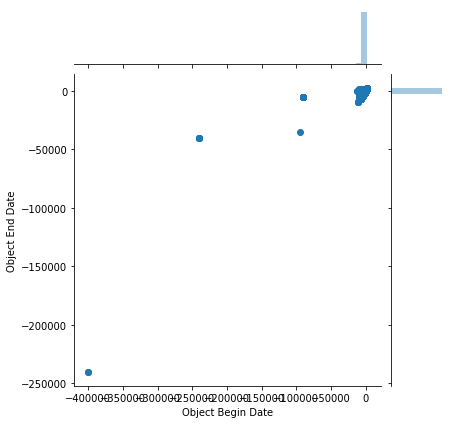

In [27]:
#Zobrazení v joint plotu pro výsledné hodnoty.
data = df4[['Object Begin Date', 'Object End Date']].dropna()
sns.jointplot(x='Object Begin Date', y='Object End Date', data=data)

### Metoda kvantilů
Zřejmě se ukazuje, že většina outlierů je spíše obrovsky záporných. Proto budu brát v potaz pouze spodní kvantil obou hodnot.

In [28]:
# Vypočítání kvantilů.
bd_Q1 = data['Object Begin Date'].quantile(0.25)
bd_Q3 = data['Object Begin Date'].quantile(0.75)
bd_IQR =  bd_Q3 - bd_Q1

ed_Q1 = data['Object End Date'].quantile(0.25)
ed_Q3 = data['Object End Date'].quantile(0.75)
ed_IQR =  ed_Q3 - ed_Q1

# Outliers pro Begin Date
bdOut = (df4['Object Begin Date'] < bd_Q1 - 1.5 * bd_IQR)
display('Begin Date Outliers: ' + str(bdOut.sum()))
display(TableDisplay(df4[bdOut].sort_values(['Object Begin Date']).head()))

# Outliers pro End Date
edOut = (df4['Object End Date'] < ed_Q1 - 1.5 * ed_IQR)
display('End Date Outliers: ' + str(edOut.sum()))
display(TableDisplay(df4[edOut].sort_values(['Object End Date']).head()))

'Begin Date Outliers: 77504'

'End Date Outliers: 71189'

### Metoda K-Means
Metodu s počítáním vkantilů jsem omezil pouze dolním kvantilem, jelikož jsem z grafu poznal, že mnohem "silnější" oulieři se nachází na nízkých hodnotách. Pomocí k-means přes oba parametry se můžeme o správnosti této volby přesvědčit. Tato metoda ovšem již neodhaluje utliery jen pro jeden z vyplněných datumů, jelikož například end date u objektů z aktuální doby nejsou často vyplněné.

In [29]:
# Získání pouze relevantních dat pomocí k-means
kmeans = KMeans(n_clusters=3, random_state=0).fit(data)
distances = kmeans.transform(data)
min_distances = pd.Series(np.apply_along_axis(min, 1, distances))
TableDisplay(df4.loc[data.iloc[min_distances.nlargest(500).index].index])

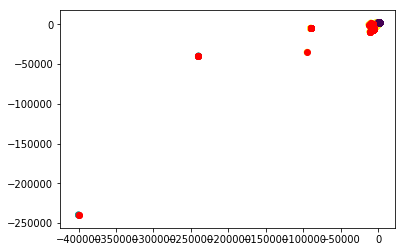

In [30]:
#Vykreslení získaných hodnot.
plt.scatter(x=data['Object Begin Date'], y=data['Object End Date'], c=kmeans.labels_)
indices = data.iloc[min_distances.nlargest(500).index].index
plt.scatter(x=data['Object Begin Date'][indices], y=data['Object End Date'][indices], c='r')

In [ ]:
#Graf bez 300 nejsilnějších outlierů.
newdata = df4.copy()
newdata.drop(data.index[min_distances.nlargest(500).index])

sns.jointplot(x='Object Begin Date', y='Object End Date', data=newdata)

## V. Doplnění hodnot
Chybějící data můžeme označit v již upravovaných sloupcích **Object Begin Date** a **Object End Date**, kde byla data zapsána nesprávně a při zjišťování jsem je z dat nahradit hodnotami nan. Nicméně tato data lze částečně vyčíst z dalšího sloupce **Date Object**, kam se zapisují jak intervaly, tak jednotlivé hodnoty pro **Object Begin Date**. Tyto sloupce jsem již dříve upravovat a proto by nyní neměl být zásadní problém pomocí Object Date doplnit informace do zbylých dvou sloupců. A naopak sloupec Object Date, kde chybí data z původních hodnot lze nastavit pomocí Object Begin Date a Object End Date. Na což bych se tedy rád zaměřil.

Mezi další sloupec, který jsem již upravoval a dá se považovat za nedostatečně vyplněný je napříkld **artist nationality**, tam by šlo například odhadovat národnost pomocí rozparsovaných příjmení.

Poslední sloupec, kde chybí data a dal by se velmi dobře doplnit, jsou Dimensions. Ty jsem se rozhodl parsovat jakožto bonusový úkol (viz. níže). Jednotlivé rozměry objektů by se pak daly velmi dobře odhadovat pomocí Object Name, Classification a případně i Medium. 

In [34]:
def findYear(d, pat):
    m = re.search(pat, str(d))
    if m:
        m = re.search('\d+', m.group(0))
        if m:
            x = int(m.group(0))
        else:
            x = np.nan
    else:
        x = np.nan
    return x

def getFromTo(d):
    n = re.search('\d+\s*(-|–)\s*\d+', str(d))
    x = np.nan
    y = np.nan
    if n:
        d = n.group(0)
        x = findYear(d, '\d+\s*(-|–)')
        y = findYear(d, '(-|–)\s*\d+')
    return [x, y]

def getObjectDate(f,t):
    if not pd.isnull(f) and not pd.isnull(t):
        return str(f) + '–' + str(t)
    if not pd.isnull(f):
        return str(f)
    if not pd.isnull(t):    
        return str(t)
    return np.nan


dat = df4.copy()
# Počet nan hodnot pro Object Date
print("Počet prázdných sloupců Object Date před doplněnín: " + dat['Object Date'].isna().sum())

newD = []
newF = []
newT = []

for index,row in dat.iterrows():
    d = row['Object Date'] 
    f = row['Object Begin Date']
    t = row['Object End Date']
    if not pd.isnull(d):
        if pd.isnull(f) and pd.isnull(t):
            y = getFromTo(d)
            f = y[0]
            t = y[1]
            
        elif pd.isnull(f) and not pd.isnull(t):
            y = getFromTo(d)
            if y[0] and y[1] == int(t):
                f = y[0]
            elif y[0] and y[1] and y[0] < y[1]:
                f = y[0]
                t = y[1]
            
        elif not pd.isnull(f) and pd.isnull(t):
            y = getFromTo(d)
            if y[0] == int(f) and y[1]:
                t = y[1]
            elif y[0] and y[1] and y[0] < y[1]:
                f = y[0]
                t = y[1]
    else:
        if not pd.isnull(f): 
            f = int(f)
        if not pd.isnull(t):
            t = int(t)
        
        n = getObjectDate(f,t)
        if n:
            d = n
    newF.append(f)
    newT.append(t)
    newD.append(d)

dat['Object Date'] = newD
dat['Object Begin Date'] = newF
dat['Object End Date'] = newT

print("Počet prázdných sloupců Object Date po doplnění:   " + dat['Object Date'].isna().sum())

15085
3


## VI. Parsování fyzických parametrů z Dimensions
Jako bonusovou úlohu jsem si vybral zpracování fyzických parametrů objektů ze sloupce Dimensions. 
Nejdříve jsem se pokusil zjistit všechny možné formáty, které se v tabulce mohou nacházet. 
Nejčastěji (odhadem 90% ) se vyskytuje varianta, že je popsán údaj v palcích a v závorce jsou dodány dané údaje v centimetrech.

Problémem byly ovšem převážně formáty, jakým stylem se popis objektu dělá. Možnosti jsou různé - Buďto se popisují výška, šířka, 
hloubka nebo průměr zvlášť a to s různými přefixy, dohromady, nebo podivně pro každou část 
objektu. Obzvlášť poslední způsob je velmi problematický jelikož nelze přesně určit, co vše
autoři hodnoty popisují případně kde se přesně nachází údaje pro cleý objekt, přípaně pokud
tam takové údaje vůbec jsou. Častá varianta u těchto problémových zápisů je zápis s "Overall:" na začátku a následný popis hlavních parametrů,
z toho důvodu níže uvedený algoritmus vezme nejdříve první řádku s overall a v něm hledá všechno
důležité, na ostatní nedbá. V opačném případě algoritmus vezme první údaje, které jsou zapsány.
To nemusí vydávat vůbec přesné výsledky, nicméně analýza jen posledního případu by mohla zabrat
několik dní neli týdnů a proto jsme se rozhodl počítat s touto nepřesnou aproximací. 

V jiných případech se vždy snažím regulárním výrazem najít popisy výšky šířky délky a průměru,
pokud vše chybí nebo u některého z nich bylo nalezeno více parametrů (například odděleno "x"), 
pak se parsují všechny hodnoty nalezené daným oddělovačem pro zbylé hodnoty (výšku, šířku...)
Tím získám jak ty parametry, které jsou uvedeny všechny v jedné závorce v centimetrech tak ty,
které jsou nevhodně uvedené na nesprávném místě, ale pohromadě. 

Do svého řešení jsem nezahrnul zpracování jednotek, protože většina záznamů je vedena v palcích 
a dále uvedena v centimetrech. Hodnoty, které nebyly uvedeny v cm, nejsou brány v potaz, nicméně
opět musím říci, že analýza všech jednotek a řešení jejich případů by zřejmě zabraly opět několik dní.
Snažil jsme se tedy se zbytkem problémů vypořádat, jak se dalo.
Výsledek zřejmě není ideální, ale aproximaticky pracuje poměrně slušně, viz. kód níže.

In [ ]:
#Zobrazení možných formátů pro Dimensions
TableDisplay(df4[['Dimensions', 'Object Number']].groupby('Dimensions').nunique())

In [ ]:
reoverall = re.compile('.*overall:.*')

# Získání výšky, šířky a hloubky jako (X x Y x Z)    
def parseXYZ(s):
    m = re.search('(\s*[0-9]+\.?[0-9]*[a-zA-Z0-9_. ]*cm)+', s)
    if m:
        f = m.group(0)
        f.replace('\s', '').replace('(', '').replace(')', '')
        a = re.findall("\d+\.?\d*", f)
        if len(a) == 0:
            return [np.nan, np.nan, np.nan, np.nan]
        if len(a) == 1:
            return [float(a[0]), np.nan, np.nan, np.nan]
        if len(a) == 2:
            return [float(a[0]), float(a[1]), np.nan, np.nan]
        else:
            return [float(a[0]),float(a[1]),float(a[2]), np.nan]
    else:
        m = re.search('\((\s*[0-9]+\.?[0-9]*[a-zA-Z0-9_,:; ]*)*\)', s)
        if m:
            f = m.group(0)
            a = re.findall("\d+\.?\d*", f)
            if len(a) > 1:
                return [float(a[0]), np.nan, np.nan, np.nan]
        return [np.nan, np.nan, np.nan, np.nan]    

# Získání parametru podle zadané předpony
def parseOnePar(charregex, s):
    m = re.search(charregex + '.*[0-9]+\.?[0-9]*[a-zA-Z0-9_. ]*cm', s)
    if m:
        f = m.group(0)
        m = re.search('(\s*[0-9]+\.?[0-9]*[a-zA-Z0-9_. ]*cm)+', f)
        if m:
            f = m.group(0)
            a = re.findall("\d+\.?\d*", f)
            if len(a) == 0:
                return [np.nan]
            if len(a) == 1:
                return [float(a[0])]
            if len(a) == 2:
                return [float(a[0]), float(a[1]), np.nan, np.nan]
            else:
                return [float(a[0]),float(a[1]),float(a[2]), np.nan]
        else: 
            return [np.nan]
    else: 
        return [np.nan]

# Získání výšky
def parseH(s):
    return parseOnePar('(h\.|height)', s) 
    
# Získání šířky    
def parseW(s):
    return parseOnePar('(w\.|width)', s) 

# Získání délky
def parseL(s):
    return parseOnePar('(l\.|length)', s)   

# Získání průměru
def parseD(s):
    return parseOnePar('(d\.|diam\.|diameter)', s) 

#Parsování parametrů
def parseParameters(s):
    if (reoverall.match(s)):
        m = re.search('overall:[^\r\n]+[\n|\r\n|\r]', s)
        if m:
            s = m.group(0)
    h = parseH(s)
    w = parseW(s)
    l = parseL(s)
    d = parseD(s)
    if (h == [np.nan] and w == [np.nan] and l == [np.nan] and d == [np.nan]): 
        return parseXYZ(s)
    if (len(h) > 1): 
        return h
    if (len(w) > 1): 
        return w
    if (len(l) > 1): 
        return l
    if (len(d) > 1):
        return d
    return h + w + l + d 

#Spuštění na každém řádku dimensions
lwhd = df4['Dimensions'].apply(lambda x: parseParameters(str(x).lower()))

#Nastavení jednotlivých parametrů
h = []
l = []
w = []
d = []
for dim in list(lwhd):
    h.append(dim[0])
    l.append(dim[1])
    w.append(dim[2])
    d.append(dim[3])
    
df4['Object Height'] = h
df4['Object Length'] = l
df4['Object Width'] = w
df4['Object Diameter'] = d 

# Výsledky parsování pro prvních 500 záznamů. (Ještě relativně sesitelné mým strojem :-) )
TableDisplay(df4[['Object Name', 'Dimensions', 'Object Height', 'Object Length', 'Object Width', 'Object Diameter']].head(500))